In [1]:
###########################################################################
# 
# 
# 
# 
# 
# Please read the 'Requirement.md' first
# 
# 
# 
# 
# 
###########################################################################

In [ ]:
###########################################################################
# Import modules
###########################################################################
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" 

import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import watershed

import torch 
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [8]:
torch.__version__
torchvision.__version__
torch.version.cuda

'1.5.1'

'0.6.1'

'10.2'

In [3]:
###########################################################################
# DIC-C2DH-HeLa CNN class
###########################################################################
class dic_cnn(nn.Module):
    def __init__(self):
        super(dic_cnn, self).__init__()
        # down
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, )
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv9 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        # up
        self.conv11 = nn.Conv2d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv13 = nn.Conv2d(in_channels=384, out_channels=128, kernel_size=3, padding=1)
        self.conv14 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv15 = nn.Conv2d(in_channels=192, out_channels=64, kernel_size=3, padding=1)
        self.conv16 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv17 = nn.Conv2d(in_channels=96, out_channels=32, kernel_size=3, padding=1)
        self.conv18 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

        # final
        self.conv19 = nn.Conv2d(in_channels=32, out_channels=2, kernel_size=1, padding = 0)

    def forward(self, images):
        res_conv1 = F.relu(self.conv1(images))
        res_conv2 = F.relu(self.conv2(res_conv1))
        res_maxpool1 = F.max_pool2d(res_conv2, kernel_size = 2, stride = 2) 

        res_conv3 = F.relu(self.conv3(res_maxpool1))
        res_conv4 = F.relu(self.conv4(res_conv3))
        res_maxpool2 = F.max_pool2d(res_conv4, kernel_size = 2, stride = 2)

        res_conv5 = F.relu(self.conv5(res_maxpool2))
        res_conv6 = F.relu(self.conv6(res_conv5))
        res_maxpool3 = F.max_pool2d(res_conv6, kernel_size = 2, stride = 2)

        res_conv7 = F.relu(self.conv7(res_maxpool3))
        res_conv8 = F.relu(self.conv8(res_conv7))
        res_maxpool4 = F.max_pool2d(res_conv8, kernel_size = 2, stride = 2)

        res_conv9 = F.relu(self.conv9(res_maxpool4))
        res_conv10 = F.relu(self.conv10(res_conv9))
        
        res_up1 = nn.Upsample(scale_factor=2, mode = 'bilinear')(res_conv10)
        res_cat1 = torch.cat((res_up1, res_conv8), dim=1)
        res_conv11 = F.relu(self.conv11(res_cat1))
        res_conv12 = F.relu(self.conv12(res_conv11))

        res_up2 = nn.Upsample(scale_factor=2, mode='bilinear')(res_conv12)
        res_cat2 = torch.cat((res_up2, res_conv6), dim=1)
        res_conv13 = F.relu(self.conv13(res_cat2))
        res_conv14 = F.relu(self.conv14(res_conv13))

        res_up3 = nn.Upsample(scale_factor=2, mode='bilinear')(res_conv14)
        res_cat3 = torch.cat((res_up3, res_conv4), dim=1)
        res_conv15 = F.relu(self.conv15(res_cat3))
        res_conv16 = F.relu(self.conv16(res_conv15))

        res_up4 = nn.Upsample(scale_factor=2, mode='bilinear')(res_conv16)
        res_cat4 = torch.cat((res_up4, res_conv2), dim=1)
        res_conv17 = F.relu(self.conv17(res_cat4))
        res_conv18 = F.relu(self.conv18(res_conv17))

        output = self.conv19(res_conv18)
        #output = F.softmax(output, dim=1)

        return output

In [4]:
###########################################################################
# Test dataset class and transform
###########################################################################

class test_dataset(data.Dataset):
    def __init__(self, root_path, sequence):
        self.root_path = root_path
        self.sequence = sequence
    def __getitem__(self, index):
        img = cv2.imread(f'{self.root_path}/{self.sequence}/t{index:03}.tif', 0)
        img = cv2.equalizeHist(img)
        img = my_transform(img).to('cuda')
        return img
    def __len__(self):
        if self.sequence in ['Sequence 1', 'Sequence 2']:
            return 84
        else:
            return 115

## define the transforms to the train dataset
my_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) ## normalize the data from [0,1] to [-1,1]
])

In [9]:
###########################################################################
# predict the detection
###########################################################################
mask_net = torch.load('(0.093)mask_net.pkl')
marker_net = torch.load('(0.042)marker_net.pkl')



def marker_postprocess(marker):
    marker = cv2.convertScaleAbs(marker)
    _, res = cv2.connectedComponents(marker)
    return res
for sequence in ['Sequence 1', 'Sequence 2','Sequence 3','Sequence 4']:
    dic_test_dataset = test_dataset('DIC-C2DH-HeLa', sequence)
    dic_test_loader = data.DataLoader(dic_test_dataset, batch_size=4)
    with torch.no_grad():
        _ = mask_net.eval()
        for i, batch in enumerate(dic_test_loader):
            batch_size = batch.shape[0]
            pred_masks = mask_net(batch).to('cpu')
            pred_markers = marker_net(batch).to('cpu')
            for j in range(batch_size):
                res_mask = pred_masks[j].argmax(0).squeeze().numpy()
                res_mask = cv2.convertScaleAbs(res_mask)
                res_marker = pred_markers[j].argmax(0).squeeze().numpy()
                res_marker = cv2.convertScaleAbs(res_marker)
                kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (18,18))
                res_marker = cv2.morphologyEx(res_marker, cv2.MORPH_OPEN, kernel)
                #res_marker = cv2.morphologyEx(res_marker, cv2.MORPH_DILATE, kernel)
                _, res_mask = cv2.threshold(res_mask, 0, 255, cv2.THRESH_BINARY)
                _, res_marker = cv2.threshold(res_marker, 0, 255, cv2.THRESH_BINARY)
                res_detection = watershed(res_mask, marker_postprocess(res_marker), mask = res_mask)
                mask = np.zeros((512, 512), dtype = np.uint8)
                for label in np.unique(res_detection)[1:]:
                    cell = ((label == res_detection)*1).astype(np.uint8)
                    _, cell = cv2.threshold(cell, 0, 255, cv2.THRESH_BINARY)
                    cell = cv2.erode(cell, np.ones([3,3]))
                    # after the erosion, some cell may be divided to 2 or more cells
                    nb, cc = cv2.connectedComponents(cell, connectivity=4)
                    if nb != 1:
                        max_size = 0
                        max_cc = 0
                        for k in range(1, nb):
                            component = (cc == k)*1
                            if (np.sum(component)) > max_size:
                                max_size = np.sum(component)
                                max_cc = k
                        res = ((max_cc == cc)*1).astype(np.uint8)
                    else:
                        res = cell
                    mask+=res
                res_detection = mask
                
                res_detection = cv2.convertScaleAbs(res_detection)
                _, res_detection = cv2.threshold(res_detection, 0, 255, cv2.THRESH_BINARY)
                #_ = cv2.imwrite(f'{dic_test_dataset.root_path}/{dic_test_dataset.sequence}_predicted_masks/predicted_mask{i*dic_test_loader.batch_size + j:03}.tif', res_mask)
                #_ = cv2.imwrite(f'{dic_test_dataset.root_path}/{dic_test_dataset.sequence}_predicted_markers/predicted_marker{i*dic_test_loader.batch_size + j:03}.tif', res_marker)
                _ = cv2.imwrite(f'{dic_test_dataset.root_path}/{dic_test_dataset.sequence}_predicted_result/predicted_result{i*dic_test_loader.batch_size + j:03}.tif', res_detection)

 version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\oyishyi\AppData\Local\Programs\Python\Python37\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\oyishyi\AppData\Local\Programs\Python\Python37\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\oyishyi\AppData\Local\Programs\Python\Python37\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in versio

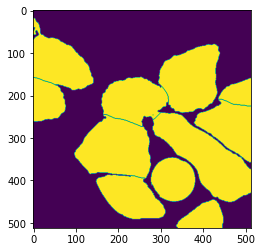

In [3]:
# test
img = cv2.imread(f'DIC-C2DH-HeLa/Sequence 3_predicted_result/predicted_result000.tif', -1)
plt.imshow(img)
plt.show()